## 使用YOLOR做detector，配合OCSORT实现目标跟踪

需要在yolor环境的基础上，额外安装`conda install -c conda-forge filterpy loguru`

In [1]:
from matplotlib import pyplot as plt
import sys
sys.path.append('../OC_SORT')
from trackers.ocsort_tracker.ocsort import OCSort

In [2]:
import os
import platform
import shutil
import time
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random

import sys
yolor_path = '/data/workspace/yuzijian/yolor'
sys.path.append(yolor_path)


from utils.google_utils import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import (
    check_img_size, non_max_suppression, apply_classifier, scale_coords, xyxy2xywh, strip_optimizer)
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized

from models.models import *
from utils.datasets import *
from utils.general import *

/data/workspace/yuzijian/miniconda3/envs/yolo/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1、跑通整个流程

In [3]:
from easydict import EasyDict

opt = EasyDict()
opt.agnostic_nms = False
opt.augment = False
opt.classes = None
opt.conf_thres = 0.5
opt.device = '2'
opt.img_size = 1280
opt.iou_thres = 0.5
opt.names = 'data/kitti.names'
opt.output = 'runs/inference'
opt.save_txt = False
opt.source = '/data/workspace/dataset/kitti_2d_detection/training/image_2/000001.png'
opt.update = False
opt.view_img = False
opt.cfg = 'cfg/yolor_w6.cfg'
opt.weights = ['weights/finetune_7_best.pt']

In [4]:
def load_classes(path):
    # Loads *.names file at 'path'
    with open(path, 'r') as f:
        names = f.read().split('\n')
    return list(filter(None, names))  # filter removes empty strings (such as last line)

In [5]:
out, source, weights, view_img, save_txt, imgsz, cfg, names = \
    opt.output, opt.source, opt.weights, opt.view_img, opt.save_txt, opt.img_size, opt.cfg, opt.names
webcam = source == '0' or source.startswith('rtsp') or source.startswith('http') or source.endswith('.txt')

# Initialize
device = select_device(opt.device)
if os.path.exists(out):
    shutil.rmtree(out)  # delete output folder
os.makedirs(out)  # make new output folder
half = device.type != 'cpu'  # half precision only supported on CUDA

# Load model
model = Darknet(cfg, imgsz).cuda()
model.load_state_dict(torch.load(weights[0], map_location=device)['model'])

model.to(device).eval()
if half:
    model.half()  # to FP16


# Get names and colors
names = load_classes(names)
colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(names))]

# Init model
img = torch.zeros((1, 3, imgsz, imgsz), device=device)  # init img
_ = model(img.half() if half else img) if device.type != 'cpu' else None  # run once

# Load image
im0 = cv2.imread(source)
image_hwc = letterbox(im0, new_shape=imgsz, auto_size=64)[0]
image_chw = np.transpose(image_hwc, (2,0,1))
img = torch.from_numpy(image_chw).to(device)
img = img.half() if half else img.float()  # uint8 to fp16/32
img /= 255.0  # 0 - 255 to 0.0 - 1.0
if img.ndimension() == 3:
    img = img.unsqueeze(0)

/data/workspace/yuzijian/miniconda3/envs/yolo/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


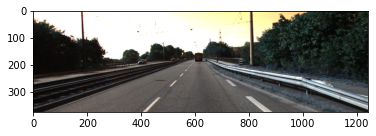

In [6]:
%matplotlib inline
plt.imshow(im0)

In [7]:
with torch.no_grad():
    # Inference
    pred = model(img, augment=opt.augment)[0]
    # Apply NMS
    pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)

In [8]:
# from detect.py line 95
for i, det in enumerate(pred):  # detections per image
    # Rescale boxes from img_size to im0 size
    print(det)
    det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
    for *xyxy, conf, cls in det:    # each pred box
        label = '%s %.2f' % (names[int(cls)], conf)
        plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=3)

tensor([[618.00000, 192.37500, 649.00000, 226.12500,   0.96191,   0.00000],
        [400.00000, 217.25000, 437.00000, 240.00000,   0.95801,   0.00000],
        [698.00000, 199.87500, 711.00000, 230.87500,   0.86914,   1.00000]], device='cuda:0')


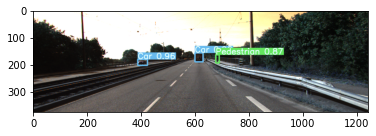

In [9]:
%matplotlib inline
plt.imshow(im0)

In [10]:
args = EasyDict()
args.track_thresh = 0.6     # detection confidence threshold
args.iou_thresh = 0.3       # the iou threshold in Sort for matching
args.deltat = 3             # time step difference to estimate direction
args.asso = "iou"           # similarity function: iou/giou/diou/ciou/ctdis
args.inertia = 0.2          # the weight of VDC term in cost matrix

tracker = OCSort(args.track_thresh, iou_threshold=args.iou_thresh, delta_t=args.deltat, 
            asso_func=args.asso, inertia=args.inertia)

In [11]:
det[..., :4], det[..., 5], det[..., 4]

(tensor([[600., 157., 630., 190.],
         [388., 181., 424., 203.],
         [677., 164., 690., 194.]], device='cuda:0'),
 tensor([0., 0., 1.], device='cuda:0'),
 tensor([0.96191, 0.95801, 0.86914], device='cuda:0'))

In [12]:
tracker.update_public(det[..., :4].cpu(), det[..., 5].cpu(), det[..., 4].cpu())

array([[        677,         164,         690,         194,           3,           1,           0],
       [        388,         181,         424,         203,           2,           0,           0],
       [        600,         157,         630,         190,           1,           0,           0]])

### 2、在kitti_raw_data上试一试

In [13]:
import glob
sources = glob.glob('/data/workspace/yuzijian/kitti_raw_data/2011_09_26/2011_09_26_drive_0015_extract/image_02/data/*.png')
frame = 0
num = len(sources)
img_dir = os.path.split(sources[0])[0]
tracker = OCSort(args.track_thresh, iou_threshold=args.iou_thresh, delta_t=args.deltat, 
            asso_func=args.asso, inertia=args.inertia)

In [212]:
source = os.path.join(img_dir, str(frame).zfill(10) + '.png')
# Load image
im0 = cv2.imread(source)
image_hwc = letterbox(im0, new_shape=imgsz, auto_size=64)[0]
image_chw = np.transpose(image_hwc, (2,0,1))
img = torch.from_numpy(image_chw).to(device)
img = img.half() if half else img.float()  # uint8 to fp16/32
img /= 255.0  # 0 - 255 to 0.0 - 1.0
if img.ndimension() == 3:
    img = img.unsqueeze(0)

# Detect & Track
with torch.no_grad():
    # Inference
    pred = model(img, augment=opt.augment)[0]
    # Apply NMS
    pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)
    # from detect.py line 95
    for i, det in enumerate(pred):  # detections per image
        # Rescale boxes from img_size to im0 size
        det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
        print(det)
        tracked = tracker.update_public(det[..., :4].cpu(), det[..., 5].cpu(), det[..., 4].cpu())
        print(tracked)
        # for *xyxy, conf, cls in det:    # each pred box
        #     label = '%s %.2f' % (names[int(cls)], conf)
        #     plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=3)
frame += 1

tensor([[6.58000e+02, 2.21000e+02, 7.36000e+02, 2.96000e+02, 9.70215e-01, 0.00000e+00],
        [5.20000e+01, 2.17000e+02, 1.48000e+02, 2.64000e+02, 9.68750e-01, 0.00000e+00],
        [1.53000e+02, 2.14000e+02, 2.31000e+02, 2.56000e+02, 9.53613e-01, 0.00000e+00],
        [2.30000e+02, 2.17000e+02, 2.91000e+02, 2.51000e+02, 9.42383e-01, 0.00000e+00],
        [8.81000e+02, 2.29000e+02, 8.94000e+02, 2.60000e+02, 8.17871e-01, 1.00000e+00]], device='cuda:0')
[[        230         217         291         251          13           0           0]
 [        881         229         894         260          12           1           0]
 [        153         214         231         256          11           0           0]
 [         52         217         148         264           9           0           0]
 [        658         221         736         296           1           0           0]]


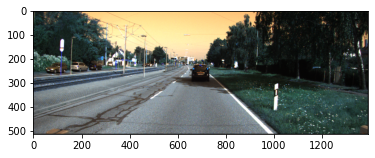

In [213]:
%matplotlib inline
plt.imshow(im0)